# European Gini coefficient treatment

In [ ]:
import pandas as pd
import csv


def fix_misaligned_columns(input_file, output_file):
    """
    Fixes misaligned columns in a CSV file where city names may span multiple columns
    and 'All Stations' marks the start of structured data.
    """
    # Read the raw data, processing row by row
    with open(input_file, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        rows = list(reader)
    
    fixed_rows = []
    for row in rows:
        # Find the position of "All Stations" in the row
        all_stations_idx = None
        for i, item in enumerate(row):
            if isinstance(item, str) and "all stations" in item.lower():
                all_stations_idx = i
                break
        
        if all_stations_idx is None:
            print(f"Warning: 'All Stations' not found in row: {row}")
            continue
        
        # Combine the city name parts (everything before 'All Stations')
        city_parts = [str(x).strip() for x in row[:all_stations_idx]] if all_stations_idx > 0 else [""]
        city = " ".join(city_parts).strip()
        
        # Reconstruct the properly aligned row
        fixed_row = [city] + row[all_stations_idx:]
        fixed_rows.append(fixed_row)
    
    # Define expected column names
    columns = ["City", "Supply_Type", "Gini_Coefficient"]
    
    # Create DataFrame
    fixed_df = pd.DataFrame(fixed_rows)
    
    # Ensure the DataFrame has at least 3 columns
    if len(fixed_df.columns) >= 3:
        fixed_df = fixed_df.iloc[:, :3]  # Keep only the first 3 columns
        fixed_df.columns = columns
    else:
        print("Error: Insufficient number of columns (less than 3)")
        return None
    
    # Save the cleaned data
    fixed_df.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"Data repair completed, saved as: {output_file}")
    return fixed_df


# Example usage
input_file = "gini_coefficients_all_EU_cities_Nowindsolar_parking.csv"
output_file = input_file.replace(".csv", "_fixed.csv")

# Process the file
fixed_data = fix_misaligned_columns(input_file, output_file)

if fixed_data is not None:
    print("\nSample of the cleaned data:")
    print(fixed_data.head())

In [ ]:
import pandas as pd
import csv


def fix_misaligned_columns(input_file, output_file):
    """
    Repairs misaligned columns in a CSV file where the 'City' name may span multiple columns,
    and alignment is determined by the position of key fields like 'power_density' or 'GHI_value'.
    """
    # Read the raw data
    with open(input_file, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        rows = list(reader)
    
    fixed_rows = []
    header = None

    for row in rows:
        # Handle header row
        if len(row) > 0 and row[0].lower() == "city" and len(row) >= 3:
            header = ["City", "Supply_Type", "Gini_Coefficient"]
            continue
        
        # Find the position of the key column ('power_density' or 'GHI_value')
        key_col_pos = None
        for i, item in enumerate(row):
            if str(item).strip() in ["power_density", "GHI_value"]:
                key_col_pos = i
                break
        
        # Skip row if key column is not found
        if key_col_pos is None:
            print(f"Warning: Key column not found in row: {row}")
            continue
        
        # Combine all parts before the key column into the City name
        city_parts = []
        for part in row[:key_col_pos]:
            if str(part).strip():  # Only include non-empty parts
                city_parts.append(str(part).strip())
        city = " ".join(city_parts)
        
        # Reconstruct the properly aligned row
        if key_col_pos + 1 < len(row):  # Ensure there are enough data columns
            fixed_row = [
                city,
                row[key_col_pos],       # Supply_Type
                row[key_col_pos + 1]    # Gini_Coefficient
            ]
            fixed_rows.append(fixed_row)
        else:
            print(f"Warning: Insufficient columns in row: {row}")
    
    # Create DataFrame
    if header:
        fixed_df = pd.DataFrame(fixed_rows, columns=header)
    else:
        fixed_df = pd.DataFrame(fixed_rows, columns=["City", "Supply_Type", "Gini_Coefficient"])
    
    # Save the cleaned data
    fixed_df.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"Data repair completed, saved as: {output_file}")
    return fixed_df


# Example usage
input_file = "gini_coefficients_all_EU_citiesWindSolar_parking.csv"
output_file = input_file.replace(".csv", "_fixed.csv")

# Process the file
fixed_data = fix_misaligned_columns(input_file, output_file)

if fixed_data is not None:
    print("\nSample of the cleaned data:")
    print(fixed_data.head())

# data merge

In [7]:
import pandas as pd

# 文件路径
file_wind_pv = 'gini_coefficients_all_EU_citiesWindSolar_parking_fixed.csv'
file_charging = 'gini_coefficients_all_EU_cities_Nowindsolar_parking_fixed.csv'

# 读取两个文件
df_wind_pv = pd.read_csv(file_wind_pv)
df_charging = pd.read_csv(file_charging)

# 处理第一个文件，拆分为风能和光伏两列
wind_data = df_wind_pv[df_wind_pv['Supply_Type'] == 'power_density'].copy()
pv_data = df_wind_pv[df_wind_pv['Supply_Type'] == 'GHI_value'].copy()

# 重命名字段便于后续合并
wind_data.rename(columns={'Gini_Coefficient': 'Gini_Wind'}, inplace=True)
pv_data.rename(columns={'Gini_Coefficient': 'Gini_PV'}, inplace=True)

# 合并风能和光伏在同一行
df_wind_pv_combined = pd.merge(wind_data[['City', 'Gini_Wind']], 
                               pv_data[['City', 'Gini_PV']], 
                               on='City', how='inner')

# 处理第二个文件（充电站）
df_charging = df_charging.rename(columns={'Gini_Coefficient': 'Gini_Charging_Station'})

# 最终合并三个基尼系数
final_df = pd.merge(df_wind_pv_combined, df_charging[['City', 'Gini_Charging_Station']], 
                    on='City', how='inner')

# 输出到CSV
output_path = 'EUmerged_gini_coefficients.csv'
final_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"✅ 数据已成功合并并保存至 {output_path}")

✅ 数据已成功合并并保存至 EUmerged_gini_coefficients.csv


In [ ]:
import pandas as pd

# File paths
file_wind_pv = 'gini_results_all_USA_CityCombinations_windsolar_parking.csv'
file_charging = 'gini_results_all_USA_CityCombinations_Nowindsolar_parking.csv'

# Read the two CSV files
df_wind_pv = pd.read_csv(file_wind_pv)
df_charging = pd.read_csv(file_charging)

# Process the first file: split into wind and PV data
wind_data = df_wind_pv[df_wind_pv['Supply_Type'] == 'power_density'].copy()
pv_data = df_wind_pv[df_wind_pv['Supply_Type'] == 'GHI_value'].copy()

# Rename Gini coefficient columns for clarity
wind_data.rename(columns={'Gini_Coefficient': 'Gini_Wind'}, inplace=True)
pv_data.rename(columns={'Gini_Coefficient': 'Gini_PV'}, inplace=True)

# Merge wind and PV data on CountyNS
df_wind_pv_combined = pd.merge(
    wind_data[['CountyNS', 'Gini_Wind']], 
    pv_data[['CountyNS', 'Gini_PV']], 
    on='CountyNS', how='inner'
)

# Process the second file (charging stations)
df_charging = df_charging.rename(columns={'Gini_Coefficient': 'Gini_Charging_Station'})

# Final merge: combine wind, PV, and charging station Gini coefficients
final_df = pd.merge(
    df_wind_pv_combined, 
    df_charging[['CountyNS', 'Gini_Charging_Station']], 
    on='CountyNS', how='inner'
)

# Export the merged data to CSV
output_path = 'USAmerged_gini_coefficients.csv'
final_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"✅ Data successfully merged and saved to {output_path}")

In [1]:
import pandas as pd

# 文件路径
file_wind_pv = 'gini_results_all_China_CityCombinations_Windsolar_parking.csv'
file_charging = 'gini_results_all_China_CityCombinations_Nowindsolar_parking.csv'

# 读取两个文件
df_wind_pv = pd.read_csv(file_wind_pv)
df_charging = pd.read_csv(file_charging)

# 处理第一个文件，拆分为风能和光伏两列
wind_data = df_wind_pv[df_wind_pv['Supply_Type'] == 'power_density'].copy()
pv_data = df_wind_pv[df_wind_pv['Supply_Type'] == 'GHI_value'].copy()

# 重命名字段便于后续合并
wind_data.rename(columns={'Gini_Coefficient': 'Gini_Wind'}, inplace=True)
pv_data.rename(columns={'Gini_Coefficient': 'Gini_PV'}, inplace=True)

# 合并风能和光伏在同一行
df_wind_pv_combined = pd.merge(wind_data[['City', 'Gini_Wind']], 
                               pv_data[['City', 'Gini_PV']], 
                               on='City', how='inner')

# 处理第二个文件（充电站）
df_charging = df_charging.rename(columns={'Gini_Coefficient': 'Gini_Charging_Station'})

# 最终合并三个基尼系数
final_df = pd.merge(df_wind_pv_combined, df_charging[['City', 'Gini_Charging_Station']], 
                    on='City', how='inner')

# 输出到CSV
output_path = 'Chinamerged_gini_coefficients高德.csv'
final_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"✅ 数据已成功合并并保存至 {output_path}")

✅ 数据已成功合并并保存至 Chinamerged_gini_coefficients高德.csv


In [2]:
import pandas as pd

# 输入路径
eu_file = 'EUmerged_gini_coefficients.csv'
us_file = 'USAmerged_gini_coefficients.csv'
china_file = 'Chinamerged_gini_coefficients高德.csv'
# 输出路径
output_file = 'GlobalGiniCoefficientsthree高德.csv'

# 读取欧洲数据并添加区域标识（可选）
df_eu = pd.read_csv(eu_file)
df_eu['Region'] = 'Europe'  # 可选：记录来源区域

# 读取美国数据并统一字段名 + 添加区域标识
df_us = pd.read_csv(us_file)
df_us.rename(columns={'CountyNS': 'City'}, inplace=True)
df_us['Region'] = 'USA'  # 可选：记录来源区域

# 读取中国数据
df_china = pd.read_csv(china_file)
df_china['Region'] = 'China'  # 可选：记录来源区域

# 合并两个数据集
combined_df = pd.concat([df_eu, df_us, df_china], ignore_index=True)

# 重新排列列顺序，确保统一结构
final_df = combined_df[['City', 'Gini_Charging_Station', 'Gini_Wind', 'Gini_PV', 'Region']]

# 输出到CSV
final_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"✅ 欧洲与美国基尼系数数据已合并完成，保存至 {output_file}")

✅ 欧洲与美国基尼系数数据已合并完成，保存至 GlobalGiniCoefficientsthree高德.csv


# Visual violin plot

# The data of the Gini coefficient of the current charging stations are consolidated

In [5]:
import pandas as pd

# 设置CSV文件路径（请根据你的实际路径修改）
csv_nowindpv = 'Combined_gini_coefficients_all_regionsNowindsolar.csv'
csv_windpv = 'Combined_gini_coefficients_all_regionsWindsolar.csv'

# 读取第一个CSV文件：仅包含充电站的基尼系数
df_nowindpv = pd.read_csv(csv_nowindpv, encoding='utf-8')

# 重命名列名为目标字段
df_nowindpv.rename(columns={
    'Gini_Coefficient': 'Gini_Charging_Station'
}, inplace=True)

# 读取第二个CSV文件：包含风能和光伏的基尼系数
df_windpv = pd.read_csv(csv_windpv, encoding='utf-8')

# 重命名列名为目标字段
df_windpv.rename(columns={
    'power_densityGini': 'Gini_Wind',
    'GHI_valueGini': 'Gini_PV'
}, inplace=True)

# 合并两个数据集：基于 City 和 Region 列进行外连接（outer join），保留所有城市
df_merged = pd.merge(
    df_nowindpv[['City', 'Region', 'Gini_Charging_Station']],
    df_windpv[['City', 'Region', 'Gini_Wind', 'Gini_PV']],
    on=['City', 'Region'],
    how='outer'
)

# 可选：填充缺失值为 NaN 或 0（根据你的需求）
# df_merged.fillna(0, inplace=True)  # 如果需要用0代替空值
df_merged.fillna(value=pd.NA, inplace=True)  # 保留 NaN 表示缺失值

# 排序（可选）：按地区排序，便于查看
df_merged.sort_values(by='Region', inplace=True)

# 输出结果到控制台查看
print(df_merged.head())

# 可选：保存为新的CSV文件
output_file = 'Currentstation_Merged_Gini_Coefficients.csv'
df_merged.to_csv(output_file, index=False, encoding='utf-8')
print(f"\n已保存合并后的数据至: {output_file}")

      City Region  Gini_Charging_Station  Gini_Wind   Gini_PV
1312  驻马店市  China               0.388135   0.341953  0.387847
1141   晋中市  China               0.308765   0.399840  0.309204
1142   晋城市  China               0.259105   0.394009  0.261948
1143   普洱市  China               0.315321   0.697282  0.313906
1144  景德镇市  China               0.106284   0.228302  0.105140

已保存合并后的数据至: Currentstation_Merged_Gini_Coefficients.csv


# Visualization of the comparison of Gini coefficients

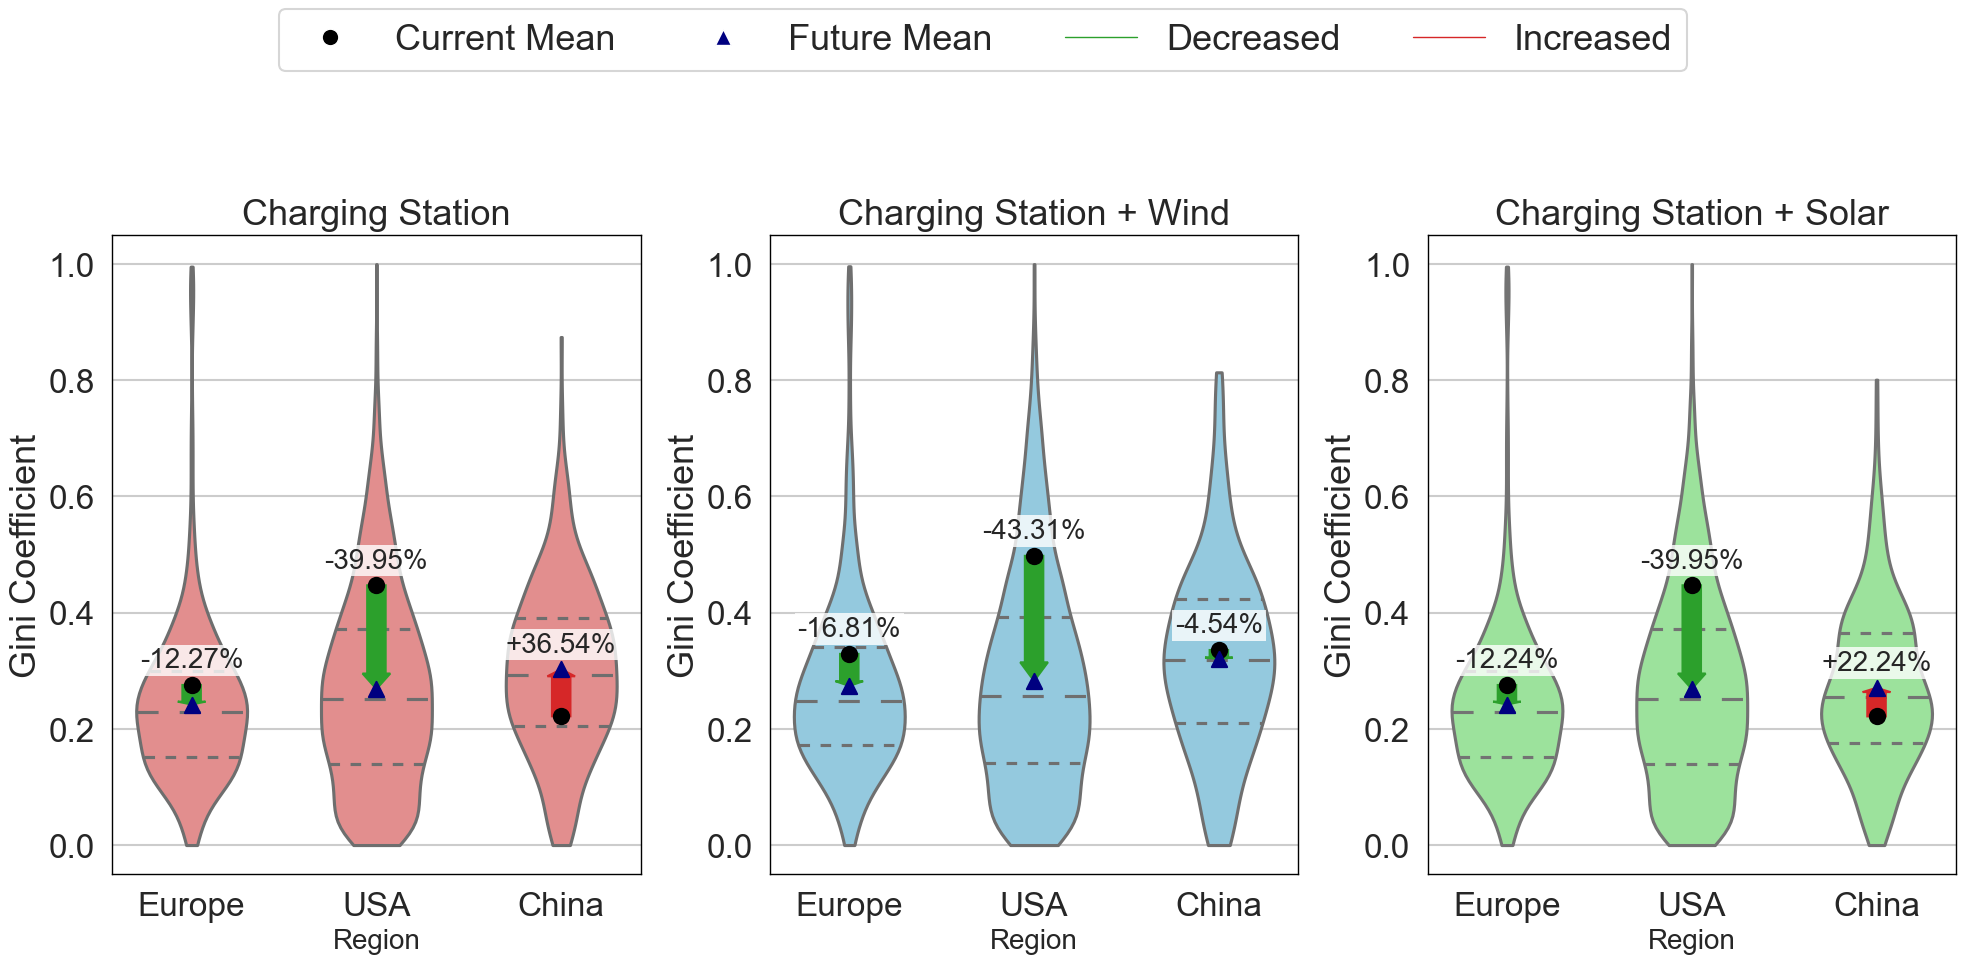


📊 基尼系数均值比较（Current vs Future）:

Charging Station:
  Europe:
    Current Mean: 0.28
    Future Mean:  0.24
    % Change:     -12.27%

  USA:
    Current Mean: 0.45
    Future Mean:  0.27
    % Change:     -39.95%

  China:
    Current Mean: 0.22
    Future Mean:  0.30
    % Change:     +36.54%

Charging Station + Wind:
  Europe:
    Current Mean: 0.33
    Future Mean:  0.27
    % Change:     -16.81%

  USA:
    Current Mean: 0.50
    Future Mean:  0.28
    % Change:     -43.31%

  China:
    Current Mean: 0.34
    Future Mean:  0.32
    % Change:     -4.54%

Charging Station + Solar:
  Europe:
    Current Mean: 0.28
    Future Mean:  0.24
    % Change:     -12.24%

  USA:
    Current Mean: 0.45
    Future Mean:  0.27
    % Change:     -39.95%

  China:
    Current Mean: 0.22
    Future Mean:  0.27
    % Change:     +22.24%



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
df_current = pd.read_csv("Currentstation_Merged_Gini_Coefficients.csv")  # Current scenario data
df_future = pd.read_csv("GlobalGiniCoefficientsthree0531.csv")           # Future scenario data

# Preprocessing: Standardize Region names
for df in [df_current, df_future]:
    df['Region'] = df['Region'].replace({'EU': 'Europe'})

# Combine current and future data with a period label
df_combined = pd.concat([
    df_current.assign(Period='Current'),
    df_future.assign(Period='Future')
])

# Select specific regions (including China)
selected_regions = ['Europe', 'USA', 'China']
df_combined = df_combined[df_combined['Region'].isin(selected_regions)]

# Calculate regional means (used for arrow positioning)
current_means = df_current.groupby('Region')[['Gini_Charging_Station', 'Gini_Wind', 'Gini_PV']].mean()
future_means = df_future.groupby('Region')[['Gini_Charging_Station', 'Gini_Wind', 'Gini_PV']].mean()

# Set Seaborn style and font
sns.set(style="whitegrid", context="talk")
plt.rcParams['font.family'] = 'Arial'

# Create a 1x3 subplot layout, wider to accommodate three regions
fig, axes = plt.subplots(1, 3, figsize=(20, 9))  # Increased width for clarity

# Function to set spine (border) properties
def set_spine_properties(ax):
    """Set the color and width of the axis spines (borders)"""
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1)

# Define metrics to plot with their column names, colors, and titles
metrics = {
    'Charging Station': {
        'col': 'Gini_Charging_Station',
        'color': 'lightcoral',
        'title': 'Charging Station'
    },
    'Charging Station + Wind': {
        'col': 'Gini_Wind',
        'color': 'skyblue',
        'title': 'Charging Station + Wind'
    },
    'Charging Station + Solar': {
        'col': 'Gini_PV',
        'color': 'lightgreen',
        'title': 'Charging Station + Solar'
    }
}

# Define arrow colors based on direction of change
arrow_colors = {
    'Decrease': '#2ca02c',  # Green for decrease in Gini
    'Increase': '#d62728'   # Red for increase in Gini
}

# Plot mixed chart: violin + mean points + change arrows
for ax, (metric_name, metric_info) in zip(axes, metrics.items()):
    # Draw violin plot for future data
    sns.violinplot(
        x='Region',
        y=metric_info['col'],
        data=df_combined[df_combined['Period'] == 'Future'],
        inner='quartile',
        scale='width',
        palette=[metric_info['color']],
        ax=ax,
        cut=0,
        width=0.6
    )
    
    # Set title and labels
    ax.set_title(metric_info['title'], fontsize=26, pad=8)
    ax.set_xlabel('Region', fontsize=20)
    ax.set_ylabel('Gini Coefficient', fontsize=26)
    ax.tick_params(axis='both', labelsize=24)
    
    # Add current mean (circle), future mean (triangle), and change arrow
    for i, region in enumerate(selected_regions):
        current_val = current_means.loc[region, metric_info['col']]
        future_val = future_means.loc[region, metric_info['col']]
        delta = future_val - current_val
        
        # Plot current mean point
        ax.scatter(
            i, current_val,
            color='black',
            marker='o',
            s=120,
            zorder=5,
            label='Current Mean' if region == 'Europe' else ''
        )
        
        # Plot future mean point
        ax.scatter(
            i, future_val,
            color='navy',
            marker='^',
            s=120,
            zorder=5,
            label='Future Mean' if region == 'Europe' else ''
        )
        
        # Draw change arrow
        arrow_props = {
            'head_width': 0.15,
            'head_length': abs(delta) * 0.15,
            'length_includes_head': True,
            'zorder': 4
        }
        ax.arrow(
            i, current_val,
            0, delta,
            color=arrow_colors['Decrease'] if delta < 0 else arrow_colors['Increase'],
            width=0.1,
            **arrow_props
        )
        
        # Compute percentage change
        percent_change = ((future_val - current_val) / current_val * 100) if current_val != 0 else float('inf')
        
        # Add percentage change label slightly above the higher value
        label_y = max(current_val, future_val) + 0.02  # Offset based on data range
        ax.text(
            i, label_y,
            f'{percent_change:+.2f}%',
            ha='center', va='bottom',
            fontsize=20,
            bbox=dict(facecolor='white', alpha=0.8, pad=2, edgecolor='none')
        )
        
        # Apply spine formatting
        set_spine_properties(ax)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Current Mean',
           markerfacecolor='black', markersize=12),
    Line2D([0], [0], marker='^', color='w', label='Future Mean',
           markerfacecolor='navy', markersize=12),
    Line2D([0], [0], color=arrow_colors['Decrease'], lw=1, label='Decreased'),
    Line2D([0], [0], color=arrow_colors['Increase'], lw=1, label='Increased')
]

# Add legend above the subplots
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, fontsize=26, frameon=True)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space at the top for the legend
# plt.savefig('Gini_Comparison_Violin_Arrows_with_China.png', dpi=300, bbox_inches='tight')  # Optional: save figure
plt.show()

# =================== NEW: Print Gini coefficient means and % changes ===================

print("\n📊 Gini Coefficient Mean Comparison (Current vs Future):\n")

# Map column names to display names
metric_labels = {
    'Gini_Charging_Station': 'Charging Station',
    'Gini_Wind': 'Charging Station + Wind',
    'Gini_PV': 'Charging Station + Solar'
}

# For each metric, compute and print current/future means and % change per region
for col_name, display_name in metric_labels.items():
    print(f"{display_name}:")
    for region in selected_regions:
        current_avg = current_means.loc[region, col_name]
        future_avg = future_means.loc[region, col_name]
        percent_change = ((future_avg - current_avg) / current_avg * 100) if current_avg != 0 else float('inf')

        print(f"  {region}:")
        print(f"    Current Mean: {current_avg:.2f}")
        print(f"    Future Mean:  {future_avg:.2f}")
        print(f"    % Change:     {percent_change:+.2f}%\n")
